# Imports

In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Loads

In [2]:
df = pd.read_csv('../csv/jobs_it_process.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _id                          3002 non-null   object 
 1   query                        3002 non-null   object 
 2   title                        3002 non-null   object 
 3   company                      3001 non-null   object 
 4   rating_mean                  3002 non-null   float64
 5   location                     3002 non-null   object 
 6   salary                       470 non-null    object 
 7   summary                      3002 non-null   object 
 8   sponso                       3002 non-null   int64  
 9   contract                     2003 non-null   object 
 10  desc                         3002 non-null   object 
 11  rating_count                 3002 non-null   int64  
 12  day_since                    3002 non-null   object 
 13  salary_origin_mode

,_id,query,title,company,rating_mean,location,salary,summary,sponso,contract,...,contract_contrat pro,contract_temps plein,contract_apprentissage,contract_stage,contract_indépendant,contract_cdd,contract_temps partiel,location_dirty,dep,salary_band
0,c5bc824b51725453,"[""data+scientist""]",Alternance - Data Scientist H/F,Malakoff Humanis,3.7,Paris 9e (75),NaN,Dans le cadre de votre alternance et en collab...,0,"Apprentissage, Contrat pro",...,1,0,1,0,0,0,0,Paris 9e,75.0,NaN
1,41984177da7622eb,"[""data+analyst"",""data+scientist""]",DATA ANALYST H/F,Groupement Les Mousquetaires,3.0,Issy-les-Moulineaux (92),NaN,Vous accompagnez la montée en compétences anal...,0,"Temps plein, CDI",...,0,1,0,0,0,0,0,Issy-les-Moulineaux,92.0,NaN
2,ecdbb413df0fc6d6,"[""data+scientist""]",Alternance - Data Scientist - Metz (F/H),Banque Populaire Alsace Lorraine Champagne,3.8,Somme,NaN,La Banque Populaire Alsace Lorraine Champagne ...,0,"Apprentissage, Contrat pro",...,1,0,1,0,0,0,0,Somme,NaN,NaN
3,51c591314452c91c,"[""data+scientist"",""developpeur""]",DATA SCIENTIST / MACHINE LEARNING RESEARCHER I...,Joko,0.0,Paris (75),NaN,Tu seras responsable du développement d'algori...,1,Stage,...,0,0,0,1,0,0,0,Paris,75.0,NaN
4,1c8dce698e6095b3,"[""data+scientist""]",Data Scientist - Maintenance prédictive des ap...,MGEN,3.1,Tours (37),NaN,Description de l'établissement ou de la direct...,1,"Apprentissage, Contrat pro",...,1,0,1,0,0,0,0,Tours,37.0,NaN


# Prepare

In [47]:
X = df.dropna(subset=['salary_mean'])[df.columns[18:33]]
y = df.dropna(subset=['salary_mean'])['salary_mean']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
print('train : {}, test : {}'.format(len(X_train), len(X_test)))

train : 328, test : 141


# n_row

In [44]:
regr_metrics = [
    ('MAE / mean', lambda x: mean_absolute_error(y_test, x), lambda x: x / y_test.mean()),
    ('MSE / mean', lambda x: mean_squared_error(y_test, x), lambda x: x / (y_test.mean()**2)),
    ('RMSE / mean', lambda x: mean_squared_error(y_test, x, squared=False), lambda x: x / y_test.mean()),
    ('R2', lambda x: r2_score(y_test, x), lambda x: x ),
    ('AR2' , lambda x : (1-(1-r2_score(y_test, x))*((len(y_test)-1)/(len(y_test)-len(X_train.columns)-1))), lambda x: x )
]
    
def check_n_row(model, metrics=[]):
    mets = np.empty((33, len(metrics)))
    for i in range(10, 331, 10):
        sample_size = min(i, len(X_train))
        mets_index = int(i/10)-1
        y_pred = model.fit(X_train[:sample_size], y_train[:sample_size]).predict(X_test)
        for j in range(len(metrics)):
            mets[mets_index, j] = metrics[j][1](y_pred)
    return mets

def plot_n_row(M, metrics=[]):
    plt.figure(figsize=(30,15))
    for i in range(len(metrics)):
        plt.plot(np.arange(M.shape[0]), metrics[i][2](M[:,i]))
    plt.legend([met[0] for met in metrics])

# Linear Regression

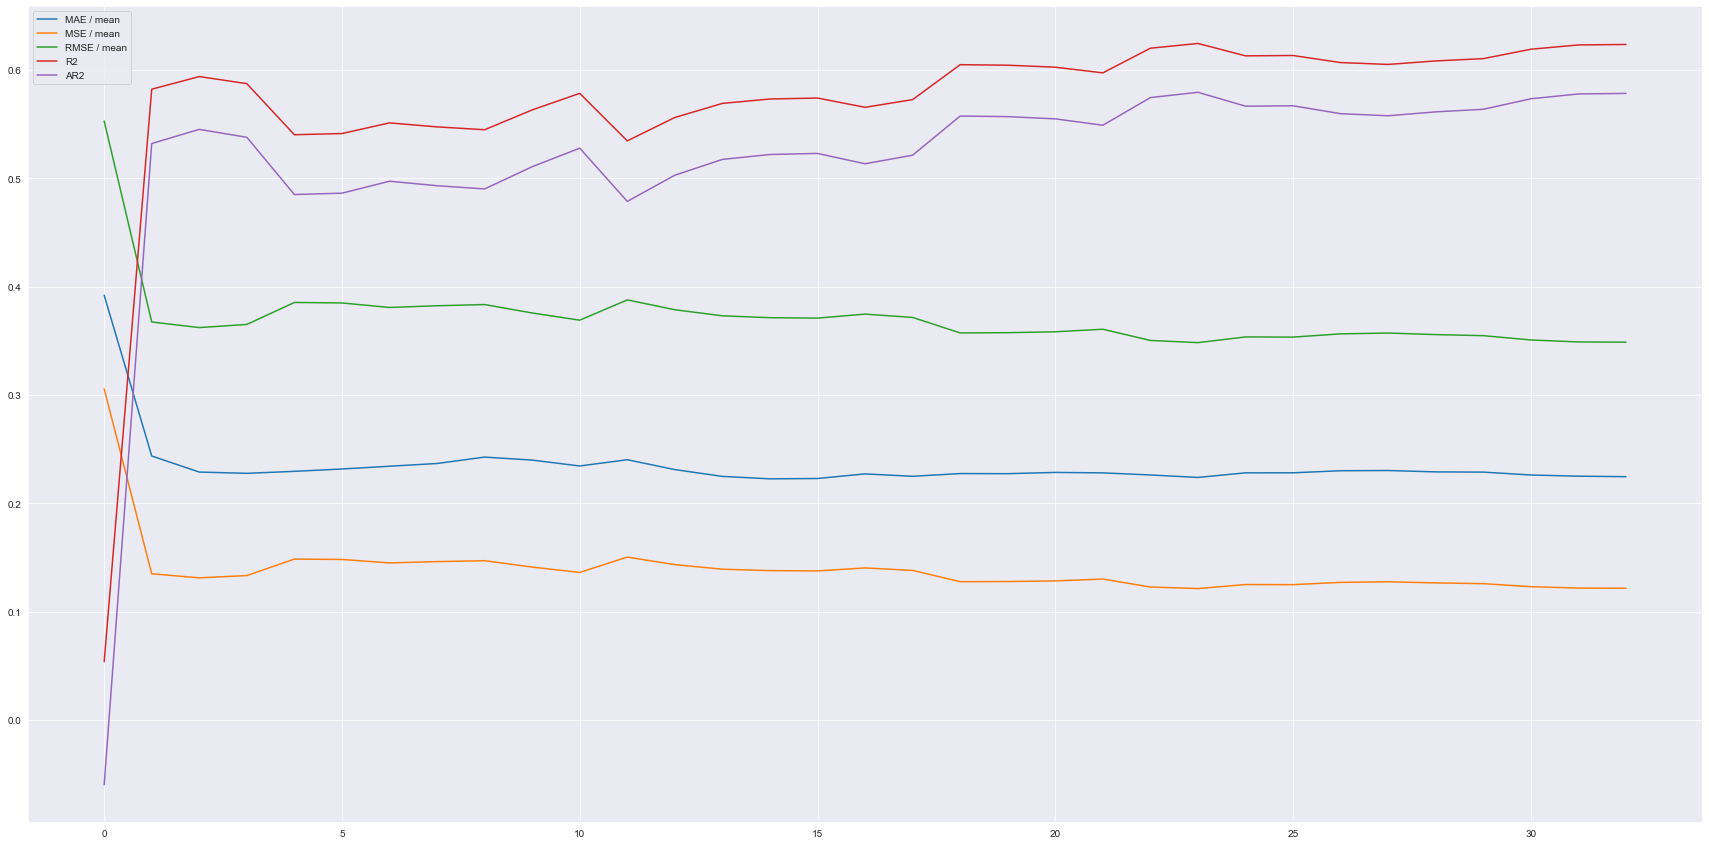

In [45]:
plot_n_row(check_n_row(LinearRegression(), metrics=regr_metrics), metrics=regr_metrics)

# XGBRegressor

## GridSearch

In [54]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
model = GridSearchCV(XGBRegressor(objective='reg:tweedie', random_state=0), params, verbose=1, n_jobs=4).fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   46.3s
[Parallel(n_jobs=4)]: Done 2025 out of 2025 | elapsed:   56.7s finished


In [55]:
print(model.best_score_)
model.best_params_

0.6807021224101563


{'colsample_bytree': 0.8,
 'gamma': 5,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 1.0}

## n_row

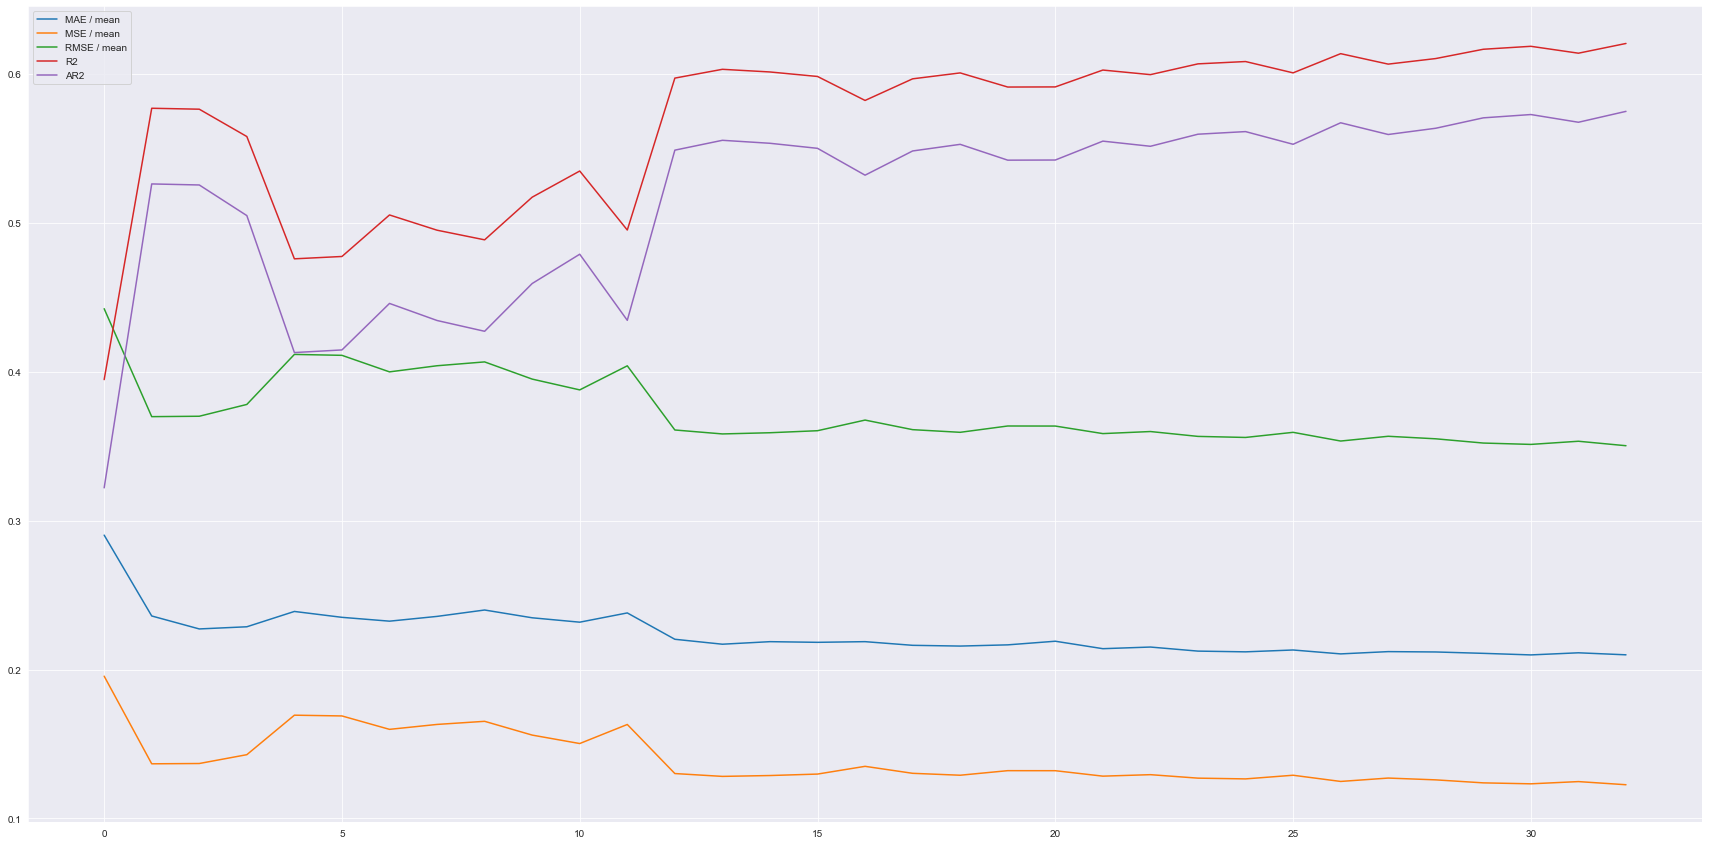

In [56]:
plot_n_row(check_n_row(
    XGBRegressor(
        objective='reg:tweedie', colsample_bytree=0.8, gamma=5, max_depth=3, 
        min_child_weight=1, subsample=1.0, random_state=0), 
    metrics=regr_metrics), metrics=regr_metrics)

# RandomForest Regressor

## GridSearch

In [63]:
params = {
     'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
model = RandomizedSearchCV(RandomForestRegressor(random_state=0), params, n_iter = 400, verbose=1, n_jobs=4).fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.6min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed: 20.3min finished


## n_row

In [64]:
print(model.best_score_)
model.best_params_

0.6604443558548458


{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

# -